In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plotly import express as px
from tqdm.auto import tqdm
from calibration import HistogramCalibrator, ScalingBinningCalibrator, OracleCalibrator, BinnedOracleCalibrator, PlattCalibrator, IsotonicCalibrator
from simulation_calibration import Simulation1, Simulation2, evaluate
%load_ext autoreload
%autoreload 2

In [2]:
sim = Simulation1()
df = sim.run()

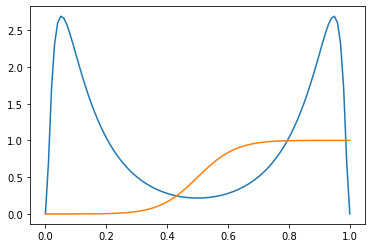

In [7]:
zz = np.linspace(0, 1, 100)
plt.plot(zz, sim.pz(zz), label='p(z)')
plt.plot(zz, sim.py_given_z(zz), label='p(y=1|z)')

In [4]:
z, y = sim.generate_data(1000)
x = sim.f_inv(z)
px.histogram(x, color=y)

In [5]:
df

,cal,sha,ref,risk,bs,n,B,i
0,1.179429e-03,3.534171e-03,0.00251,0.004714,0.007224,100,6,0
1,2.162325e-03,1.804147e-02,0.00251,0.020204,0.022714,100,6,1
2,2.611213e-03,2.849727e-02,0.00251,0.031108,0.033619,100,6,2
3,1.237385e-02,2.494212e-03,0.00251,0.014868,0.017378,100,11,0
4,2.222918e-03,1.519738e-02,0.00251,0.017420,0.019931,100,11,1
...,...,...,...,...,...,...,...,...
205,8.913842e-07,2.875376e-06,0.00251,0.000004,0.002514,10000000,569,1
206,8.034285e-07,2.909824e-06,0.00251,0.000004,0.002514,10000000,569,2
207,1.870977e-06,1.020945e-06,0.00251,0.000003,0.002513,10000000,1000,0
208,1.436479e-06,1.040472e-06,0.00251,0.000002,0.002513,10000000,1000,1


cal vs. B 0.790689764996003
cal vs. n -0.9880598759291346
sha vs. B -1.8296774049612332


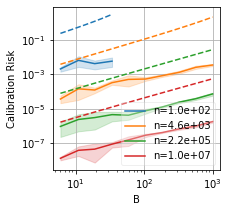

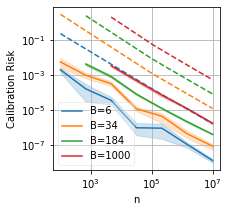

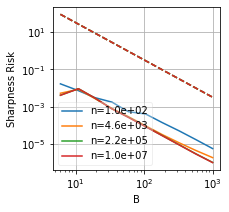

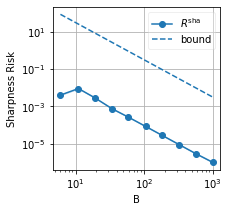

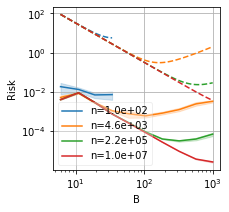

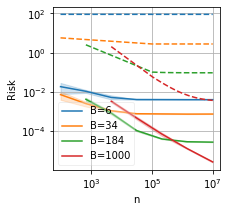

<Figure size 216x216 with 0 Axes>

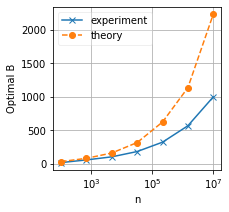

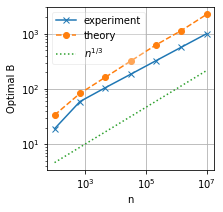

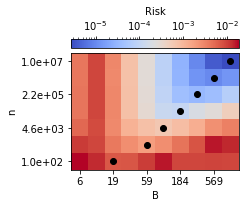

In [6]:
sim.plot(df)

## Compare with Kumar

### Case 1: Mixture of Gaussians

In [9]:
sim = Simulation1()
df = sim.run_calibrators_asymp()
df

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/6 [00:00<?, ?it/s]

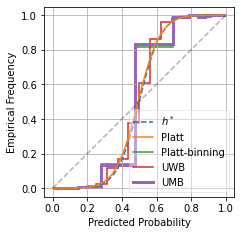

In [16]:
n = 4000
seed = 3
np.random.seed(seed)
n = n
if B is None:
    B = round(1 * (n ** (1/3)))
z, y = sim.generate_data(n)

platt = PlattCalibrator().fit(z, y)
sb = ScalingBinningCalibrator(n_bins=B).fit(z, y)
calibrators = {
    'Optimal':          OracleCalibrator(sim.py_given_z),
    'UMB':              HistogramCalibrator(n_bins=B, strategy='quantile').fit(z, y),
    'UWB':              HistogramCalibrator(n_bins=B, strategy='uniform').fit(z, y),
    'Platt-binning':    ScalingBinningCalibrator(n_bins=B).fit(z, y),
    'Platt':            PlattCalibrator().fit(z, y),
    'Platt-oracle':       BinnedOracleCalibrator(sb.bins, platt, sim.pz),
    # 'Isotonic':         IsotonicCalibrator().fit(z, y),
}

# plot
calibrators['Optimal'].plot(label='$h^*$', ls='--', lw=1.5)
calibrators['Platt'].plot(label='Platt', lw=1.5)
calibrators['Platt-binning'].plot(label='Platt-binning', lw=1.5)
calibrators['UWB'].plot(label='UWB', lw=1.5)
calibrators['UMB'].plot(label='UMB', lw=3, set_layout=True)
plt.savefig('sim_compare_methods.pdf', bbox_inches='tight')

# table
metrics = []
for name, calibrator in tqdm(calibrators.items()):
    m = evaluate(calibrator, sim.py_given_z, sim.pz)
    for k, v in m.items():
        metrics.append({
            'Calibrator': name,
            'Metric': k,
            'Value': v,
        })
df = pd.DataFrame(metrics)

columns = {'cal': '$\REL$', 'sha': '$\GRP$', 'risk': '$R$', 'bs': 'MSE'}
indices = ['Platt', 'Platt-oracle', 'Platt-binning', 'UWB', 'UMB'] # slice(None)  # ['Platt', 'Platt-binning', 'UMB']
df_wide = (
    df
    .set_index(['Calibrator', 'Metric'])['Value'].unstack(-1)
    .loc[indices, columns.keys()]
    .reindex(indices)
    .rename(columns=columns)
    .rename_axis(None, axis=0)
)
df_str = (df_wide.style
    .highlight_min(axis=0, props='bfseries: ;', subset=[c for c in df_wide if c not in ['Method', 'Estimator']])
    .format(precision=6)
    .to_latex(hrules=True, column_format='c' * (df_wide.shape[1] + 1))
)

In [17]:
df_wide

Metric,$\REL$,$\GRP$,$R$,MSE
Platt,0.000032,0.000000,0.000032,0.002543
Platt-oracle,0.000023,0.002370,0.002393,0.004903
Platt-binning,0.000059,0.002370,0.002429,0.004940
UWB,0.000114,0.000221,0.000335,0.002845
UMB,0.000104,0.002370,0.002474,0.004985


In [14]:
df_wide.loc['Platt-oracle', '$\\REL$']

0.0

In [4]:
from tqdm.auto import trange
from uncertainties import ufloat
from multiprocessing import Pool

sim = Simulation1()
n = 4000
B = round(n ** (1/3))
print(B)
df_wide_list = []

# for seed in trange(10):
#     df_wide, df_str = sim.run_calibrators(n=n, B=B, seed=seed)
#     df_wide_list.append(df_wide)

def f(seed):
    df_wide, df_str = sim.run_calibrators(n=n, B=B, seed=seed)
    return df_wide * 1e3

with Pool() as pool:
    df_wide_list = pool.map(f, range(20))

dfc = pd.concat(df_wide_list)
dfc = dfc.groupby(dfc.index)
dfc = dfc.agg(lambda s: ufloat(s.mean(), s.std()))
dfc

16


Metric,$\REL$,$\GRP$,$R$,MSE
Platt,0.04+/-0.05,0.0+/-0,0.04+/-0.05,2.55+/-0.05
Platt-binning,0.04+/-0.05,2.41+/-0.33,2.45+/-0.31,4.96+/-0.31
UMB,0.07+/-0.06,2.41+/-0.33,2.48+/-0.31,4.99+/-0.31
UWB,0.18+/-0.11,0.221153510846672285+/-0.000000000000000028,0.40+/-0.11,2.92+/-0.11


In [67]:
dfc.loc['Platt', '$\REL$']

0.03674238558338228+/-0.045179389169981585

(array([10.,  3.,  2.,  0.,  0.,  2.,  1.,  1.,  0.,  1.]),
 array([0.00035016, 0.01570688, 0.03106359, 0.04642031, 0.06177703,
        0.07713375, 0.09249046, 0.10784718, 0.1232039 , 0.13856061,
        0.15391733]),
 <BarContainer object of 10 artists>)

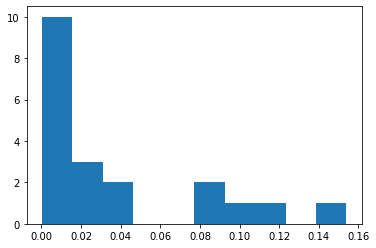

In [71]:
plt.hist(np.array(aa) * 1e3)

In [77]:
aa = [d.loc['Platt', '$\REL$'] for d in df_wide_list]
bb = [d.loc['Platt-binning', '$\REL$'] for d in df_wide_list]
aa, bb = np.array(aa), np.array(bb)
aa - bb

array([ 2.60355381e-06,  8.07237558e-06,  5.35876138e-06, -2.69062477e-05,
       -1.82769878e-05,  3.70790664e-05, -1.49112033e-06, -5.56539667e-06,
       -3.00996557e-06,  1.18909754e-05, -2.09991815e-05,  2.25739792e-06,
        1.69988000e-06,  3.64367288e-05, -5.73339513e-05, -1.05165448e-05,
        3.92206351e-06, -3.18958860e-06,  3.02034703e-07,  4.68331702e-06])

In [1]:
df_wide_list[3]

NameError: name 'df_wide_list' is not defined

In [ ]:
np.random.seed(seed)
n = n
if B is None:
    B = round(1 * (n ** (1/3)))
z, y = self.generate_data(n)

calibrators = {
    'Optimal':          OracleCalibrator(self.py_given_z),
    'UMB':              HistogramCalibrator(n_bins=B, strategy='quantile').fit(z, y),
    'UWB':              HistogramCalibrator(n_bins=B, strategy='uniform').fit(z, y),
    'Platt-binning':    ScalingBinningCalibrator(n_bins=B).fit(z, y),
    'Platt':            PlattCalibrator().fit(z, y),
    # 'Isotonic':         IsotonicCalibrator().fit(z, y),
}

# plot
calibrators['Optimal'].plot(label='$h^*$', ls='--', lw=1.5)
calibrators['Platt'].plot(label='Platt', lw=1.5)
calibrators['Platt-binning'].plot(label='Platt-binning', lw=1.5)
calibrators['UWB'].plot(label='UWB', lw=1.5)
calibrators['UMB'].plot(label='UMB', lw=3, set_layout=True)
plt.savefig('sim_compare_methods.pdf', bbox_inches='tight')

# table
metrics = []
for name, calibrator in tqdm(calibrators.items()):
    m = evaluate(calibrator, self.py_given_z, self.pz)
    for k, v in m.items():
        metrics.append({
            'Calibrator': name,
            'Metric': k,
            'Value': v,
        })
df = pd.DataFrame(metrics)

columns = {'cal': '$\REL$', 'sha': '$\GRP$', 'risk': '$R$', 'bs': 'MSE'}
indices = ['Platt', 'Platt-binning', 'UWB', 'UMB'] # slice(None)  # ['Platt', 'Platt-binning', 'UMB']
df_wide = (
    df
    .set_index(['Calibrator', 'Metric'])['Value'].unstack(-1)
    .loc[indices, columns.keys()]
    .reindex(indices)
    .rename(columns=columns)
    .rename_axis(None, axis=0)
)
df_str = (df_wide.style
    .highlight_min(axis=0, props='bfseries: ;', subset=[c for c in df_wide if c not in ['Method', 'Estimator']])
    .format(precision=6)
    .to_latex(hrules=True, column_format='c' * (df_wide.shape[1] + 1))
)

  0%|          | 0/5 [00:00<?, ?it/s]

Metric,$\REL$,$\GRP$,$R$,MSE
Platt,0.000032,0.000000,0.000032,0.002543
Platt-binning,0.000059,0.002370,0.002429,0.004940
UWB,0.000114,0.000221,0.000335,0.002845
UMB,0.000104,0.002370,0.002474,0.004985


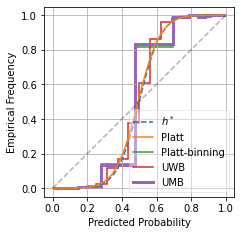

In [80]:
df_wide, df_str = sim.run_calibrators(n=n, B=B, seed=3)
df_wide

16


  0%|          | 0/5 [00:00<?, ?it/s]

\begin{tabular}{ccccc}
\toprule
Metric & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & 0.000003 & \bfseries 0.000000 & \bfseries 0.000003 & \bfseries 0.002514 \\
Platt-binning & \bfseries 0.000001 & 0.002899 & 0.002900 & 0.005410 \\
UWB & 0.000205 & 0.000221 & 0.000426 & 0.002937 \\
UMB & 0.000028 & 0.002899 & 0.002927 & 0.005438 \\
\bottomrule
\end{tabular}



Metric,$\REL$,$\GRP$,$R$,MSE
Platt,3.474648e-06,0.000000,0.000003,0.002514
Platt-binning,8.710938e-07,0.002899,0.002900,0.005410
UWB,2.052468e-04,0.000221,0.000426,0.002937
UMB,2.845624e-05,0.002899,0.002927,0.005438


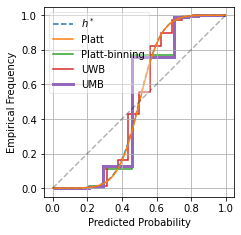

In [32]:
sim = Simulation1()
n = 4000
B = round(n ** (1/3))
print(B)
df_wide, df_str = sim.run_calibrators(n=n, B=B, seed=0)
print(df_str)
df_wide

In [30]:
(df_wide * 1000).style.format(precision=3)

Metric,$\REL$,$\GRP$,$R$,MSE
Platt,0.065,0.000,0.065,2.575
Platt-binning,0.065,3.877,3.942,6.452
UWB,0.154,0.195,0.349,2.860
UMB,0.074,3.877,3.951,6.461


It can be seen that Scaling-binning achieves lower REL than Platt scaling.
Lower than UWB and UMB, -- benefits of parametric method

### Case 2: Beta calibration

17


/x/home/zeyusun/work/wip/simulation_calibration.py:324: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (1 + 1 / (np.exp(self.c) * z ** self.a / (1 - z) ** self.b))


  0%|          | 0/5 [00:00<?, ?it/s]

\begin{tabular}{ccccc}
\toprule
Metric & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & 0.00299 & \bfseries 0.00000 & 0.00299 & 0.02391 \\
Platt-binning & 0.00287 & 0.00035 & 0.00322 & 0.02413 \\
UWB & \bfseries 0.00043 & 0.00036 & \bfseries 0.00079 & \bfseries 0.02171 \\
UMB & 0.00045 & 0.00035 & 0.00080 & 0.02171 \\
\bottomrule
\end{tabular}



Metric,$\REL$,$\GRP$,$R$,MSE
Platt,0.002990,0.000000,0.002990,0.023908
Platt-binning,0.002871,0.000346,0.003217,0.024134
UWB,0.000434,0.000359,0.000793,0.021710
UMB,0.000451,0.000346,0.000797,0.021714


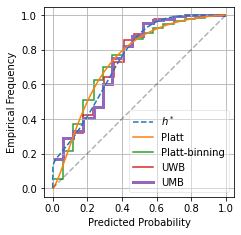

In [27]:
sim = Simulation2(a=0.1, b=5, m=0.25)
n = 5000
B = round(n ** (1/3))
print(B)
df_wide, df_str = sim.run_calibrators(n=n, B=B, seed=0)
print(df_str)
df_wide